# Reddit Sentiment Analisis

## Cambiamento climatico

Nell'era digitale, i Social Network rappresentano un mezzo fondamentale per esprimere opinioni e condividere pensieri su temi di rilevanza globale. Tra le questioni più discusse negli ultimi anni, il cambiamento climatico occupa una posizione di rilievo, mobilitando opinioni contrastanti e stimolando un dibattito globale.

L'idea alla base di questo progetto è quella di analizzare il pensiero comune espresso dagli utenti riguardo il cambiamento climatico, raccogliendo dati da Reddit, una delle piattaforme di discussione più utilizzate per approfondimenti tematici e dibattiti. Verranno selezionati diversi subreddit rilevanti, come "climate", "globalwarming" e altri simili, per creare un dataset che rifletta le opinioni espresse dagli utenti in diverse comunità online.

Il dataset sarà costruito raccogliendo post e commenti relativi a parole chiave specifiche (es. "climate change", "ecoanxiety"), con l'obiettivo di condurre un'analisi approfondita del sentiment e delle emozioni associate. Per garantire una visione complessiva, i dati saranno analizzati utilizzando tecniche avanzate di Natural Language Processing (NLP), tra cui l'impiego del modello RoBERTa e di librerie dedicate all'analisi del sentiment ed emozionale.

Il progetto mira a classificare i contenuti in sentiment positivi, negativi e neutri, e ad approfondire le emozioni prevalenti (es. ansia, gioia, rabbia). Questa analisi consentirà di comprendere meglio le percezioni, i timori e le speranze delle persone riguardo al cambiamento climatico, con l'obiettivo di fornire uno strumento utile per monitorare il dibattito e l'evoluzione del pensiero collettivo su uno dei temi più critici del nostro tempo.

## Autenticazione API di Reddit

In [1]:
import praw
from dotenv import load_dotenv
import os

def authenticate_reddit():
    reddit = praw.Reddit(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        user_agent=USER_AGENT,
        check_for_async=False  # Importante per evitare errori di asincronia
    )
    return reddit

# Carica file env
load_dotenv(dotenv_path="reddit.env")

# Impostazioni API di Reddit (da configurare con le proprie credenziali)
CLIENT_ID = os.getenv("client_id")
CLIENT_SECRET = os.getenv("client_secret")
USER_AGENT = os.getenv("user_agent")

reddit = authenticate_reddit()


## Creazione Dataset

In [2]:
from textblob import TextBlob
import pandas as pd
import re
from transformers import pipeline

# Funzione per pulire il testo dei post
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Rimuove i link
    text = re.sub(r'[^a-zA-Z ]', '', text)  # Rimuove caratteri speciali
    text = text.lower()  # Converte in minuscolo
    return text

# Funzione per raccogliere i post basati su una parola chiave
def fetch_reddit_posts(reddit, subreddits, limit):
    post_data = []
    for sub_name in subreddits:
        try:
            sub = reddit.subreddit(sub_name)
            print(sub_name)
            posts = sub.top(limit=limit)
            for post in posts:    
                cleaned_text = clean_text(post.title + ' ' + post.selftext)
                sentiment_label, sentiment_score, emotion_label, emotion_score = analyze_text_roberta(
                    cleaned_text, sentiment_analyzer, emotion_analyzer
                )
                post_data.append({
                    'subreddit': sub_name,
                    'title': post.title,
                    'text': cleaned_text,
                    'sentiment': analyze_sentiment(sentiment_label),
                    'sentiment_score': sentiment_score,
                    'emotion': emotion_label,
                    'emotion_score': emotion_score
                })
        except praw.exceptions.APIException as e:
            print(f"API error on subreddit {sub_name}: {e}")
        except Exception as e:
            print(f"Error fetching data from subreddit {sub_name}: {e}")
    return pd.DataFrame(post_data)

def analyze_sentiment(text):
    # Mappatura delle etichette del modello
    sentiment_mapping = {
        "LABEL_0": "negative",
        "LABEL_1": "neutral",
        "LABEL_2": "positive"
    }
    return sentiment_mapping[text]  # Mappa la label al valore comprensibile


def split_text(text, max_length=370): #RoBERTa accetta fino a massimo 512 caratteri, non so perché questa funzione non va come aspettato
    words = text.split()
    for i in range(0, len(words), max_length):
        yield ' '.join(words[i:i + max_length])
        
# Funzione per analizzare il sentiment e le emozioni con RoBERTa
def analyze_text_roberta(text, sentiment_analyzer, emotion_analyzer):
    sentiments = []
    emotions = []
    for chunk in split_text(text):
        sentiment_result = sentiment_analyzer(chunk)[0]
        emotion_result = emotion_analyzer(chunk)[0]
        sentiments.append((sentiment_result['label'], sentiment_result['score']))
        emotions.append((emotion_result['label'], emotion_result['score']))
    
    # Combina i risultati dei blocchi (puoi personalizzare la logica di combinazione)
    avg_sentiment_score = sum([score for _, score in sentiments]) / len(sentiments)
    avg_emotion_score = sum([score for _, score in emotions]) / len(emotions)
    # Ritorna la label e il punteggio medio
    return sentiments[0][0], avg_sentiment_score, emotions[0][0], avg_emotion_score

# Esecuzione principale
if __name__ == "__main__":
    # Lista subreddit tematici
    subreddits = ["climate", "climatechange", "climateactionplan",
                 "environment", "renewableenergy"]
    post_limit = 1000
    
    #variabili roBERTa
    sentiment_analyzer = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
    emotion_analyzer = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base")
    
    print("Raccolta dei post da Reddit in corso...")
    posts_df = fetch_reddit_posts(reddit, subreddits, post_limit)
    print(posts_df.head())

    # Mostra informazioni aggiuntive sul dataset
    print(f"Numero totale di post raccolti: {len(posts_df)}")

Device set to use cpu
Device set to use cpu


Raccolta dei post da Reddit in corso...
climate
climatechange
climateactionplan
environment
renewableenergy
  subreddit                                              title  \
0   climate  Milton Is the Hurricane That Scientists Were D...   
1   climate  The MAGA Plan to End Free Weather Reports | Pr...   
2   climate  Electing Kamala Harris over Trump is necessary...   
3   climate  Climate Groups Warn Third-Party Vote 'Could Ha...   
4   climate  Bill Gates on why he’ll carry on using private...   

                                                text sentiment  \
0  milton is the hurricane that scientists were d...  negative   
1  the maga plan to end free weather reports  pro...  negative   
2  electing kamala harris over trump is necessary...   neutral   
3  climate groups warn thirdparty vote could hand...  negative   
4  bill gates on why hell carry on using private ...  negative   

   sentiment_score  emotion  emotion_score  
0         0.530652     fear       0.987567  
1       

## Analisi risultati

Visualizzazione del sentiment...


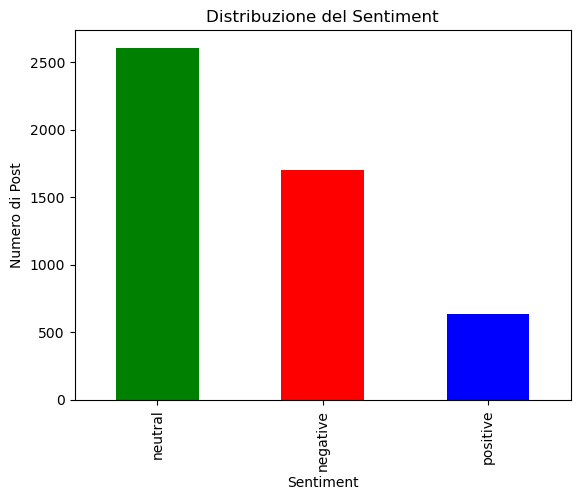

Visualizzazione delle emozioni...


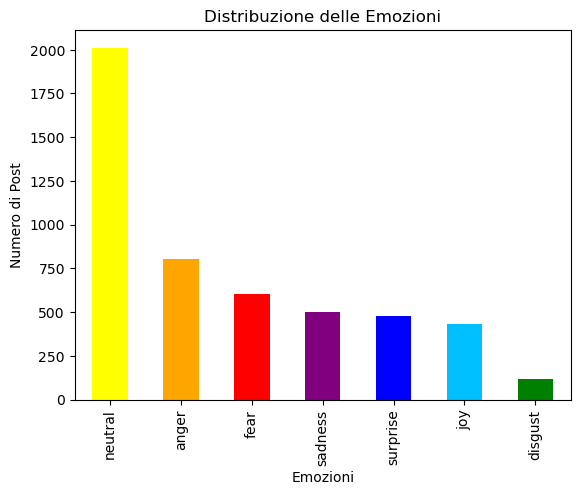

In [3]:
import matplotlib.pyplot as plt

# Funzione per visualizzare i risultati del sentiment
def plot_sentiment(df):
    sentiment_counts = df['sentiment'].value_counts()
    sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
    plt.title('Distribuzione del Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Numero di Post')
    plt.show()

# Funzione per visualizzare i risultati delle emozioni
def plot_emotions(df):
    emotion_counts = df['emotion'].value_counts()
    emotion_counts.plot(kind='bar', color=['yellow', 'orange', 'red', 'purple', 'blue', 'deepskyblue', 'green'])
    plt.title('Distribuzione delle Emozioni')
    plt.xlabel('Emozioni')
    plt.ylabel('Numero di Post')
    plt.show()


print("Visualizzazione del sentiment...")
plot_sentiment(posts_df)

print("Visualizzazione delle emozioni...")
plot_emotions(posts_df)


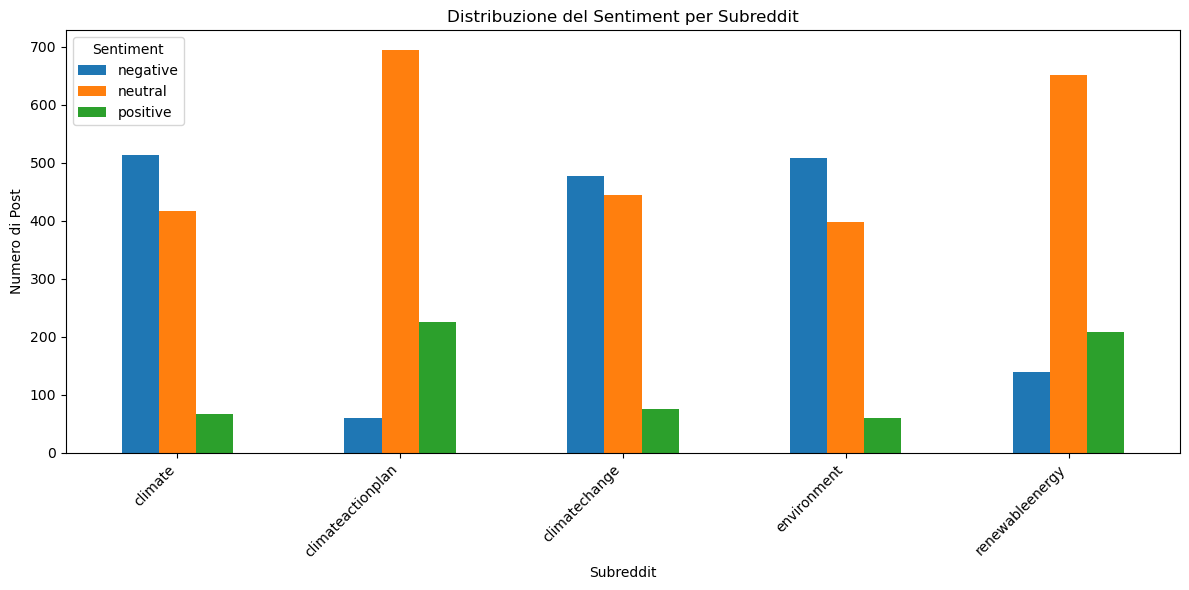

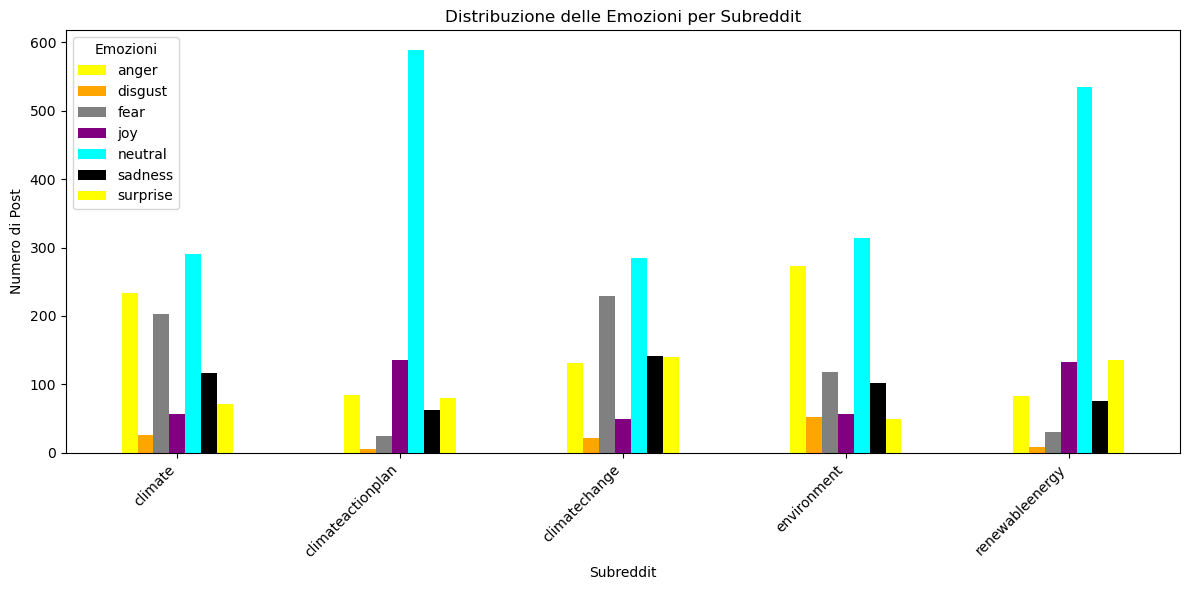

In [4]:
def plot_sentiment_by_subreddit(df):
    # Aggrega i dati per subreddit e sentiment
    sentiment_counts = df.groupby(['subreddit', 'sentiment']).size().unstack(fill_value=0)

    # Crea il grafico a barre raggruppato
    sentiment_counts.plot(kind='bar', figsize=(12, 6))
    plt.title('Distribuzione del Sentiment per Subreddit')
    plt.xlabel('Subreddit')
    plt.ylabel('Numero di Post')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Sentiment")
    plt.tight_layout()
    plt.show()

def plot_emotion_by_subreddit(df):
    # Aggrega i dati per subreddit e emozione
    emotion_counts = df.groupby(['subreddit', 'emotion']).size().unstack(fill_value=0)

    # Crea il grafico a barre raggruppato
    emotion_counts.plot(kind='bar', figsize=(12, 6), color=['yellow', 'orange', 'gray', 'purple', 'cyan', 'black'])
    plt.title('Distribuzione delle Emozioni per Subreddit')
    plt.xlabel('Subreddit')
    plt.ylabel('Numero di Post')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Emozioni")
    plt.tight_layout()
    plt.show()

plot_sentiment_by_subreddit(posts_df)
plot_emotion_by_subreddit(posts_df)

## WordClouds

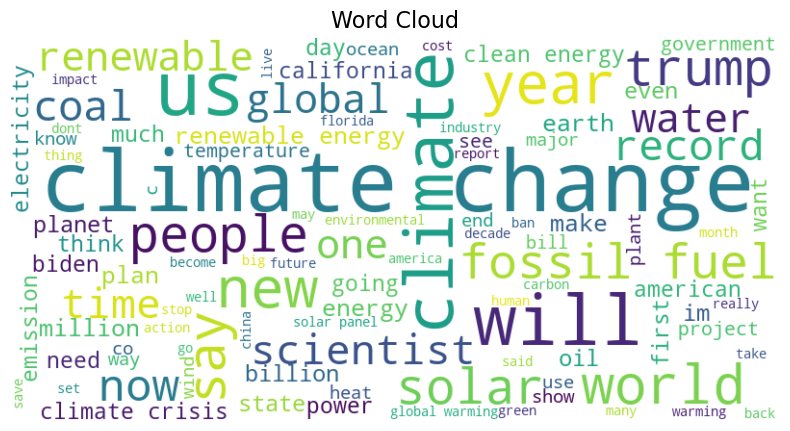

In [5]:
from wordcloud import WordCloud


# Unisce tutti i testi della colonna specificata in un'unica stringa
combined_text = ' '.join(posts_df['text'].astype(str).tolist())
    
# Genera il WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=100
).generate(combined_text)
    
# Visualizza il WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud', fontsize=16)
plt.axis('off')
plt.show()

## WordCloud by sentiment

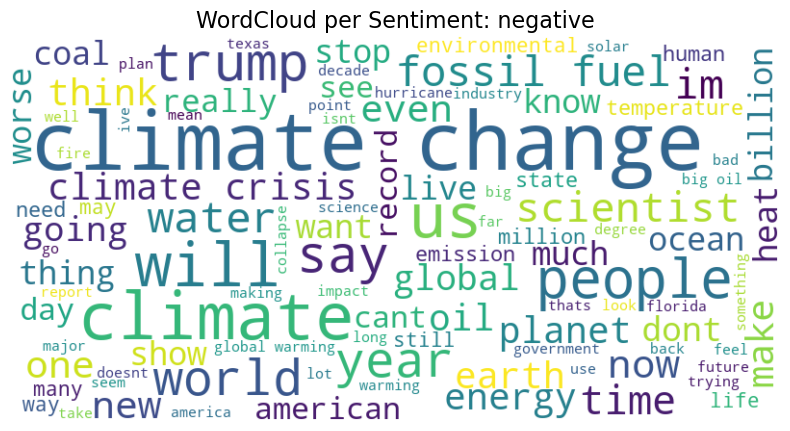

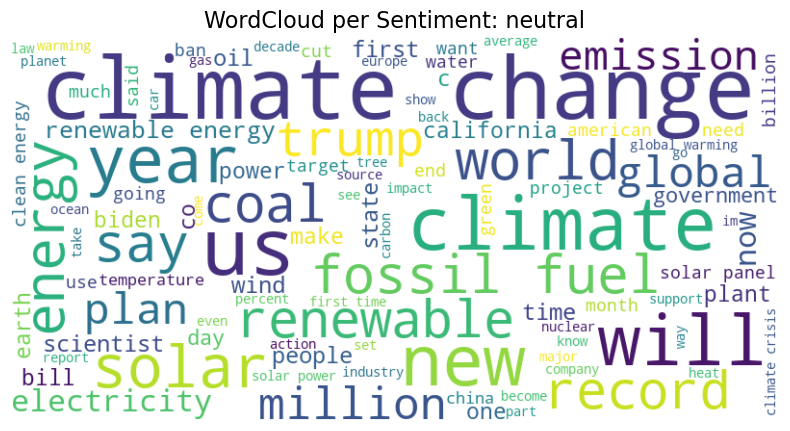

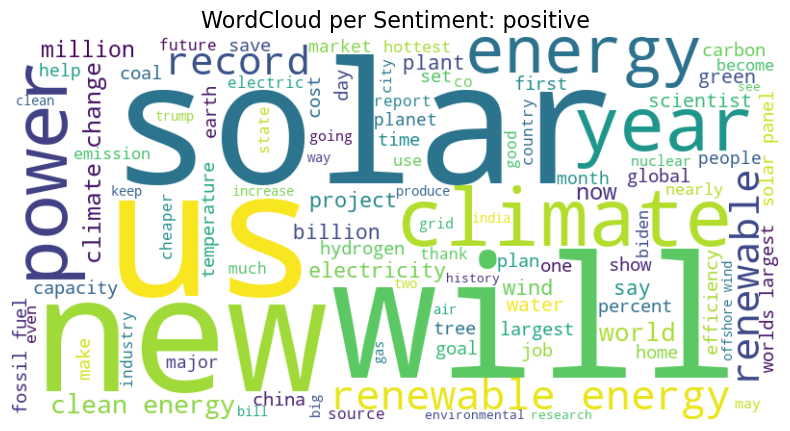

In [6]:
# Ottieni i sentiment unici
unique_sentiments = posts_df['sentiment'].unique()
    
for sentiment in unique_sentiments:
    # Filtra il DataFrame per il sentiment specifico
    filtered_df = posts_df[posts_df['sentiment'] == sentiment]
        
    # Combina tutto il testo in una sola stringa
    combined_text = ' '.join(filtered_df['text'].astype(str).tolist())
        
    # Genera il WordCloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=100
    ).generate(combined_text)
        
    # Visualizza il WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"WordCloud per Sentiment: {sentiment}", fontsize=16)
    plt.axis('off')
    plt.show()
